# IMDB文本分类示例

使用CNN和LSTM模型进行情感分类

数据集准备：
1. 下载数据集：
   wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

2. 解压数据集：
   tar -xzf aclImdb_v1.tar.gz

3. 查看数据集大小：
   - find aclImdb/train/pos -type f | wc -l  # 查看训练集正面评论数量
   - find aclImdb/train/neg -type f | wc -l  # 查看训练集负面评论数量
   - find aclImdb/test/pos -type f | wc -l   # 查看测试集正面评论数量
   - find aclImdb/test/neg -type f | wc -l   # 查看测试集负面评论数量

4. 运行脚本时，请确保aclImdb目录在当前目录下

GPU支持：
- 如果检测到GPU，将自动使用GPU进行训练
- 可以通过设置USE_GPU=False强制使用CPU

In [17]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2025-03-30 18:28:06--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  52.3MB/s    in 1.5s    

2025-03-30 18:28:08 (52.3 MB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]



In [32]:
!pwd

/content


In [33]:
!ls

aclImdb  aclImdb_v1.tar.gz  aclImdb_v1.tar.gz.1  sample_data


In [34]:
!tar -xzf aclImdb_v1.tar.gz

In [35]:
!find aclImdb/train/pos -type f | wc -l

12500


这行代码是一个 Unix/Linux 命令行操作，它结合了两个命令（`find` 和 `wc`）通过管道操作符（`|`）连接起来。

解释如下：

1. `find aclImdb/train/pos -type f`：
   - `find` 是查找文件的命令
   - `aclImdb/train/pos` 是要搜索的路径或目录
   - `-type f` 指定只查找常规文件（不包括目录、符号链接等）

2. `|`：管道操作符，将第一个命令的输出作为第二个命令的输入

3. `wc -l`：
   - `wc` 是文本计数工具（word count）
   - `-l` 选项表示只计算行数

整体功能：这行代码统计 aclImdb/train/pos 目录下所有常规文件的数量。

这是在处理 IMDB 电影评论数据集，其中 aclImdb/train/pos 目录通常包含训练集中的正面（positive）评论文件。该命令会计算出正面评论文件的总数量。

In [36]:
!find aclImdb/train/pos/0_9.txt -type f | wc -l

1


In [37]:
!cat aclImdb/train/pos/0_9.txt

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!

"cat" 命令的名称源自英文单词 "concatenate"（连接）的缩写。

这个命令的设计初衷是将多个文件的内容连接（concatenate）在一起并输出到标准输出。例如：

```
cat file1.txt file2.txt file3.txt
```

这个命令会将三个文件的内容依次连接并显示出来。

虽然我们现在常常只用 cat 来显示单个文件内容（如 `cat file.txt`），但它的真正功能是可以连接多个文件。这也是为什么它被命名为 "cat" 的原因 - 它是 "concatenate" 的简写。

这个命令是 Unix 早期开发的基本命令之一，体现了 Unix 哲学中的一个核心原则：创建做一件事并做好的小工具，然后通过管道和重定向将它们组合起来完成复杂任务。

## 导包

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

## GPU设置

In [39]:
USE_GPU = True  # 设置为False可以强制使用CPU
device = torch.device('cuda' if USE_GPU and torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [40]:
class IMDBDataset(Dataset):
    def __init__(self, split='train', max_samples=None, data_dir="aclImdb"):
        self.data = []
        self.labels = []
        self.data_dir = data_dir

        # 加载IMDB数据
        self._load_imdb(split, max_samples)

    def _load_imdb(self, split, max_samples):
        # 检查数据集目录是否存在
        if not os.path.exists(self.data_dir):
            raise FileNotFoundError(
                f"数据集目录 {self.data_dir} 不存在。请先下载并解压数据集：\n"
                "1. wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz\n"
                "2. tar -xzf aclImdb_v1.tar.gz"
            )

        # 加载数据
        base_path = os.path.join(self.data_dir, split)
        pos_path = os.path.join(base_path, 'pos')
        neg_path = os.path.join(base_path, 'neg')

        # 读取正面评论
        for filename in os.listdir(pos_path)[:max_samples//2 if max_samples else None]:
            if filename.endswith('.txt'):
                with open(os.path.join(pos_path, filename), 'r', encoding='utf-8') as f:
                    self.data.append(f.read().lower())
                    self.labels.append(1)

        # 读取负面评论
        for filename in os.listdir(neg_path)[:max_samples//2 if max_samples else None]:
            if filename.endswith('.txt'):
                with open(os.path.join(neg_path, filename), 'r', encoding='utf-8') as f:
                    self.data.append(f.read().lower())
                    self.labels.append(0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [41]:
def preprocess_text(text):
    """
    简单的文本预处理函数

    功能:
    1. 将文本转换为小写 (lower())
    2. 去除文本首尾的空白字符 (strip())
    3. 将文本分割成单词列表 (split())

    参数:
    text (str): 需要处理的原始文本

    返回:
    list: 处理后的单词列表
    """
    return text.lower().strip().split()


In [42]:
def build_vocab(texts, min_freq=5):
    """构建词汇表

    Args:
        texts: 文本列表
        min_freq: 最小词频阈值，词频低于此值的词不会被加入词表
    """
    # 统计词频
    word_freq = {}
    for text in texts:
        for word in preprocess_text(text):
            word_freq[word] = word_freq.get(word, 0) + 1

    # 根据词频阈值筛选词表
    vocabulary = set(word for word, freq in word_freq.items() if freq >= min_freq)

    # 添加特殊token
    vocabulary.add("<pad>")
    vocabulary.add("<unk>")

    # 创建词到索引的映射
    word_to_ix = {word: idx for idx, word in enumerate(sorted(list(vocabulary)))}
    return word_to_ix

In [43]:
def convert_text_to_indices(text, word_to_ix, max_len=500):
    """将文本转换为索引序列"""
    tokens = preprocess_text(text)[:max_len]
    indices = []
    for token in tokens:
        if token in word_to_ix:
            indices.append(word_to_ix[token])
        else:
            indices.append(word_to_ix["<unk>"])

    # 填充到固定长度
    if len(indices) < max_len:
        indices.extend([word_to_ix["<pad>"]] * (max_len - len(indices)))
    return indices

In [46]:
def collate_fn(batch):
    """
    整理批次数据，将原始数据转换为模型可接受的格式

    参数:
        batch: 一个包含多个样本的列表，每个样本是一个元组 (text_indices, label)
               其中 text_indices 是文本的数字索引列表，label 是对应的标签

    处理步骤:
    1. 解包批次数据，分离文本索引和标签
    2. 将文本索引列表转换为张量
    3. 将所有文本张量堆叠为一个批次张量
    4. 将标签列表转换为张量

    返回:
        tuple: 包含两个元素:
            - 文本索引的批次张量，形状为 [batch_size, seq_length]
            - 标签的批次张量，形状为 [batch_size]
    """
    # 解包批次数据，将文本和标签分开
    # 假设每个 batch 元素是 (text_indices, label) 的形式
    texts, labels = zip(*batch)

    # 将每个文本的索引列表转换为 PyTorch 张量
    # 类型设置为 torch.long，适合存储词汇表索引
    text_indices = [torch.tensor(text, dtype=torch.long) for text in texts]

    # 堆叠所有文本张量成一个批次张量并返回标签张量
    # 注意: torch.stack 要求所有张量具有相同维度，如果文本长度不同可能需要使用 padding_collate_fn
    return torch.stack(text_indices), torch.tensor(labels)


In [50]:
# 创建三个相同形状的张量
tensor1 = torch.tensor([1, 2, 3])
tensor2 = torch.tensor([4, 5, 6])
tensor3 = torch.tensor([7, 8, 9])

print("原始张量:")
print("tensor1:", tensor1, "形状:", tensor1.shape)
print("tensor2:", tensor2, "形状:", tensor2.shape)
print("tensor3:", tensor3, "形状:", tensor3.shape)

# 使用 torch.stack 在新维度(dim=0)上堆叠张量
stacked_tensors = torch.stack([tensor1, tensor2, tensor3], dim=0)
print("\n在新维度0上堆叠后:")
print(stacked_tensors)
print("堆叠后形状:", stacked_tensors.shape)  # 应该是 [3, 3]

# 可以在不同维度上堆叠
stacked_tensors_dim1 = torch.stack([tensor1, tensor2, tensor3], dim=1)
print("\n在新维度1上堆叠后:")
print(stacked_tensors_dim1)
print("堆叠后形状:", stacked_tensors_dim1.shape)  # 应该是 [3, 3]

原始张量:
tensor1: tensor([1, 2, 3]) 形状: torch.Size([3])
tensor2: tensor([4, 5, 6]) 形状: torch.Size([3])
tensor3: tensor([7, 8, 9]) 形状: torch.Size([3])

在新维度0上堆叠后:
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
堆叠后形状: torch.Size([3, 3])

在新维度1上堆叠后:
tensor([[1, 4, 7],
        [2, 5, 8],
        [3, 6, 9]])
堆叠后形状: torch.Size([3, 3])


## `torch.cat` 和 `torch.stack` 的区别

1. **维度处理方式**:
   - `torch.stack`: 创建一个新的维度来堆叠张量
   - `torch.cat`: 沿着已有的维度连接张量，不创建新维度

2. **输出形状**:
   - `torch.stack`: 如果输入是 n 个形状为 [a, b] 的张量，在 dim=0 堆叠后形状变为 [n, a, b]
   - `torch.cat`: 如果输入是 n 个形状为 [a, b] 的张量，在 dim=0 连接后形状为 [n*a, b]

3. **输入要求**:
   - `torch.stack`: 要求所有输入张量形状完全相同
   - `torch.cat`: 只要求待连接维度之外的其他维度相同

In [53]:
# 创建三个相同形状的张量
tensor1 = torch.tensor([[1, 2, 3]])
tensor2 = torch.tensor([[4, 5, 6]])
tensor3 = torch.tensor([[7, 8, 9]])

# stack操作 - 创建新维度
stacked = torch.stack([tensor1, tensor2, tensor3], dim=0)
print("Stack结果:")
print(stacked)
print("形状:", stacked.shape)  # 形状: torch.Size([3, 3])

# cat操作 - 在现有维度上连接
cat_result = torch.cat([tensor1, tensor2, tensor3], dim=0)
print("\nCat结果:")
print(cat_result)
print("形状:", cat_result.shape)  # 形状: torch.Size([9])

# 如果要用cat实现类似stack的效果，需要先增加维度
tensor1_unsqueezed = tensor1.unsqueeze(0)  # 形状变为 [1, 3]
tensor2_unsqueezed = tensor2.unsqueeze(0)
tensor3_unsqueezed = tensor3.unsqueeze(0)

cat_unsqueezed = torch.cat([tensor1_unsqueezed, tensor2_unsqueezed, tensor3_unsqueezed], dim=0)
print("\nCat结果(先unsqueeze):")
print(cat_unsqueezed)
print("形状:", cat_unsqueezed.shape)  # 形状: torch.Size([3, 3])
print("与stack结果相同?", torch.all(cat_unsqueezed == stacked).item())


print('=' * 50)

# 这些张量形状相同，都是 [3]
a = torch.tensor([1, 2, 3])           # 形状: [3]
b = torch.tensor([4, 5, 6])           # 形状: [3]

# 可以成功堆叠
stacked = torch.stack([a, b], dim=0)  # 结果形状: [2, 3]
print("成功堆叠:", stacked)

# 错误示例：形状不同的张量
c = torch.tensor([7, 8, 9, 10])       # 形状: [4]
try:
    # 这会失败，因为a和c形状不同
    torch.stack([a, c], dim=0)
except RuntimeError as e:
    print("堆叠形状不同的张量出错:", e)

print('=' * 50)

# 示例1: 一维张量连接
a = torch.tensor([1, 2, 3])           # 形状: [3]
c = torch.tensor([7, 8, 9, 10])       # 形状: [4]

# 可以沿着维度0连接，因为它们都是一维张量
concat1 = torch.cat([a, c], dim=0)    # 结果形状: [7]
print("\n连接不同长度的一维张量:", concat1)

# 示例2: 二维张量连接
d = torch.tensor([[1, 2, 3],
                  [4, 5, 6]])          # 形状: [2, 3]
e = torch.tensor([[7, 8, 9]])          # 形状: [1, 3]

# 沿着第一维度(dim=0)连接 - 第一维度可以不同，但第二维度必须相同
concat2 = torch.cat([d, e], dim=0)     # 结果形状: [3, 3]
print("\n沿着第一维度连接:", concat2)

# 示例3: 错误情况
f = torch.tensor([[1, 2],
                 [3, 4]])             # 形状: [2, 2]

try:
    # 这会失败，因为d和f的第二维度不同(3 vs 2)
    torch.cat([d, f], dim=0)
except RuntimeError as e:
    print("\n连接不匹配张量出错:", e)

# 但我们可以沿着第二维度(dim=1)连接大小不同的向量

# d形状[2,3]，f形状[2,2]，第一维度相同，可以沿第二维度连接
concat3 = torch.cat([d, f], dim=1)     # 结果形状: [2, 7]
print("\n沿第二维度连接:", concat3)


Stack结果:
tensor([[[1, 2, 3]],

        [[4, 5, 6]],

        [[7, 8, 9]]])
形状: torch.Size([3, 1, 3])

Cat结果:
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
形状: torch.Size([3, 3])

Cat结果(先unsqueeze):
tensor([[[1, 2, 3]],

        [[4, 5, 6]],

        [[7, 8, 9]]])
形状: torch.Size([3, 1, 3])
与stack结果相同? True
成功堆叠: tensor([[1, 2, 3],
        [4, 5, 6]])
堆叠形状不同的张量出错: stack expects each tensor to be equal size, but got [3] at entry 0 and [4] at entry 1

连接不同长度的一维张量: tensor([ 1,  2,  3,  7,  8,  9, 10])

沿着第一维度连接: tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

连接不匹配张量出错: Sizes of tensors must match except in dimension 0. Expected size 3 but got size 2 for tensor number 1 in the list.

沿第二维度连接: tensor([[1, 2, 3, 1, 2],
        [4, 5, 6, 3, 4]])


In [54]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_filters, filter_sizes, num_classes, dropout=0.5):
        super(TextCNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # CNN层
        self.convs = nn.ModuleList([
            nn.Conv1d(embed_dim, num_filters, fs)
            for fs in filter_sizes
        ])

        # 全连接层
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: (batch, seq_len)
        embedded = self.embedding(x)  # (batch, seq_len, embed_dim)

        # 准备卷积输入
        embedded = embedded.transpose(1, 2)  # (batch, embed_dim, seq_len)

        # 应用CNN
        conv_outputs = []
        for conv in self.convs:
            conv_out = torch.relu(conv(embedded))
            pool_out = torch.max_pool1d(conv_out, conv_out.shape[2])
            conv_outputs.append(pool_out)

        # 合并所有卷积结果
        combined = torch.cat(conv_outputs, dim=1).squeeze(-1)
        combined = self.dropout(combined)
        out = self.fc(combined)

        return out

In [173]:
class TextLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=2, dropout=0.5):
        super(TextLSTM, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.dropout = nn.Dropout(dropout)

        self.lstm = nn.LSTM(embed_dim,
                           hidden_dim,
                           num_layers=num_layers,
                           bidirectional=True,
                           batch_first=True,)
                          #  dropout=dropout if num_layers > 1 else 0)

        # 添加批归一化
        self.bn = nn.BatchNorm1d(hidden_dim * 2)

        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        # embedded = self.dropout(embedded)

        lstm_out, _ = self.lstm(embedded)

        # print(lstm_out.size())

        # 使用平均池化而不是只取最后一个时间步
        # avg_pool = torch.mean(lstm_out, dim=1)
        avg_pool = lstm_out[:, -1, :]

        # print(avg_pool.size())

        # # 应用批归一化
        # normed = self.bn(avg_pool)
        # out = self.dropout(normed)
        # out = self.fc(out)

        out = self.fc(avg_pool)

        return out

In [174]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_dir='models'):
    """训练模型

    Args:
        model: 模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        criterion: 损失函数
        optimizer: 优化器
        num_epochs: 训练轮数
        device: 训练设备
        save_dir: 模型保存目录
    """
    # 创建保存目录
    os.makedirs(save_dir, exist_ok=True)

    best_val_acc = 0
    model_name = model.__class__.__name__

    # 记录训练过程
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for texts, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            texts, labels = texts.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)

            loss.backward()

            # # 添加梯度裁剪
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_acc = 100. * correct / total

        # 验证阶段
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total

        # 记录历史
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            # 保存最佳模型
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'history': history
            }, os.path.join(save_dir, f'best_{model_name}.pth'))

    # 绘制训练曲线
    plt.figure(figsize=(12, 4))

    # 损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(save_dir, f'{model_name}_training_curves.png'))
    plt.close()

    return history

In [175]:
def predict_sentiment(model, text, word_to_ix, device, max_len=500):
    """预测文本情感

    Args:
        model: 加载好的模型
        text: 输入文本
        word_to_ix: 词到索引的映射
        device: 设备
        max_len: 最大序列长度

    Returns:
        sentiment: 情感预测结果（0为负面，1为正面）
        probability: 预测概率
    """
    model.eval()
    with torch.no_grad():
        # 预处理文本
        indices = convert_text_to_indices(text, word_to_ix, max_len)
        input_tensor = torch.tensor(indices).unsqueeze(0).to(device)

        # 预测
        outputs = model(input_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        predicted = torch.argmax(outputs, dim=1)

        return predicted.item(), probabilities[0][predicted].item()

In [176]:
MAX_SAMPLES = 2000  # 每个类别的最大样本数
MAX_LEN = 300      # 文本最大长度

EMBED_DIM = 200
NUM_FILTERS = 128
FILTER_SIZES = [3, 4, 5]
HIDDEN_DIM = 256
NUM_LAYERS = 2
NUM_CLASSES = 2
BATCH_SIZE = 32
NUM_EPOCHS =20
LEARNING_RATE = 0.001

word_to_ix = None  # 初始化为None

In [177]:
def main():

    global word_to_ix

    # 加载数据
    print("Loading datasets...")
    train_dataset = IMDBDataset(split='train', max_samples=MAX_SAMPLES)
    test_dataset = IMDBDataset(split='test', max_samples=MAX_SAMPLES)

    # 划分训练集和验证集
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    # 构建词汇表
    word_to_ix = build_vocab([text for text, _ in train_dataset])

    # 转换文本为索引
    train_indices = [(convert_text_to_indices(text, word_to_ix, MAX_LEN), label)
                     for text, label in train_dataset]
    val_indices = [(convert_text_to_indices(text, word_to_ix, MAX_LEN), label)
                   for text, label in val_dataset]
    test_indices = [(convert_text_to_indices(text, word_to_ix, MAX_LEN), label)
                    for text, label in test_dataset]

    # 创建数据加载器
    train_loader = DataLoader(train_indices,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            collate_fn=collate_fn)
    val_loader = DataLoader(val_indices,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          collate_fn=collate_fn)
    test_loader = DataLoader(test_indices,
                           batch_size=BATCH_SIZE,
                           shuffle=False,
                           collate_fn=collate_fn)

    criterion = nn.CrossEntropyLoss()

    # 训练CNN模型
    print("\nTraining CNN model...")
    cnn_model = TextCNN(
        vocab_size=len(word_to_ix),
        embed_dim=EMBED_DIM,
        num_filters=NUM_FILTERS,
        filter_sizes=FILTER_SIZES,
        num_classes=NUM_CLASSES
    ).to(device)

    optimizer = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)

    cnn_history = train_model(cnn_model, train_loader, val_loader, criterion, optimizer,
                            NUM_EPOCHS, device, save_dir='models')

    # 训练LSTM模型
    print("\nTraining LSTM model...")
    lstm_model = TextLSTM(
        vocab_size=len(word_to_ix),
        embed_dim=EMBED_DIM,
        hidden_dim=HIDDEN_DIM,
        num_classes=NUM_CLASSES,
        num_layers=NUM_LAYERS
    ).to(device)

    optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)

    lstm_history = train_model(lstm_model, train_loader, val_loader, criterion, optimizer,
                             NUM_EPOCHS, device, save_dir='models')

Loading datasets...

Training LSTM model...


Epoch 1/20: 100%|██████████| 50/50 [00:03<00:00, 16.49it/s]


Epoch 1: Train Loss: 0.6975, Train Acc: 49.94%, Val Loss: 0.7019, Val Acc: 46.25%


Epoch 2/20: 100%|██████████| 50/50 [00:02<00:00, 17.84it/s]


Epoch 2: Train Loss: 0.6787, Train Acc: 54.19%, Val Loss: 0.7023, Val Acc: 52.00%


Epoch 3/20: 100%|██████████| 50/50 [00:02<00:00, 17.10it/s]


Epoch 3: Train Loss: 0.6386, Train Acc: 56.69%, Val Loss: 0.7832, Val Acc: 46.25%


Epoch 4/20: 100%|██████████| 50/50 [00:02<00:00, 17.00it/s]


Epoch 4: Train Loss: 0.5766, Train Acc: 60.50%, Val Loss: 0.9086, Val Acc: 48.00%


Epoch 5/20: 100%|██████████| 50/50 [00:02<00:00, 16.79it/s]


Epoch 5: Train Loss: 0.5525, Train Acc: 60.69%, Val Loss: 1.0453, Val Acc: 47.50%


Epoch 6/20: 100%|██████████| 50/50 [00:02<00:00, 17.14it/s]


Epoch 6: Train Loss: 0.5524, Train Acc: 61.81%, Val Loss: 1.0213, Val Acc: 52.50%


Epoch 7/20: 100%|██████████| 50/50 [00:03<00:00, 16.48it/s]


Epoch 7: Train Loss: 0.5465, Train Acc: 62.69%, Val Loss: 1.0762, Val Acc: 47.75%


Epoch 8/20: 100%|██████████| 50/50 [00:02<00:00, 16.70it/s]


Epoch 8: Train Loss: 0.5455, Train Acc: 60.56%, Val Loss: 1.0959, Val Acc: 47.50%


Epoch 9/20: 100%|██████████| 50/50 [00:03<00:00, 16.55it/s]


Epoch 9: Train Loss: 0.5417, Train Acc: 62.00%, Val Loss: 1.1785, Val Acc: 53.25%


Epoch 10/20: 100%|██████████| 50/50 [00:02<00:00, 16.74it/s]


Epoch 10: Train Loss: 0.5410, Train Acc: 61.50%, Val Loss: 1.2319, Val Acc: 47.00%


Epoch 11/20: 100%|██████████| 50/50 [00:03<00:00, 16.46it/s]


Epoch 11: Train Loss: 0.5397, Train Acc: 62.44%, Val Loss: 1.2303, Val Acc: 47.25%


Epoch 12/20: 100%|██████████| 50/50 [00:03<00:00, 16.47it/s]


Epoch 12: Train Loss: 0.5394, Train Acc: 62.50%, Val Loss: 1.2709, Val Acc: 48.00%


Epoch 13/20: 100%|██████████| 50/50 [00:03<00:00, 14.56it/s]


Epoch 13: Train Loss: 0.5377, Train Acc: 61.25%, Val Loss: 1.3497, Val Acc: 47.25%


Epoch 14/20: 100%|██████████| 50/50 [00:03<00:00, 16.46it/s]


Epoch 14: Train Loss: 0.5412, Train Acc: 59.81%, Val Loss: 1.3281, Val Acc: 52.75%


Epoch 15/20: 100%|██████████| 50/50 [00:02<00:00, 16.69it/s]


Epoch 15: Train Loss: 0.5625, Train Acc: 59.31%, Val Loss: 1.0622, Val Acc: 46.75%


Epoch 16/20: 100%|██████████| 50/50 [00:03<00:00, 16.52it/s]


Epoch 16: Train Loss: 0.5593, Train Acc: 61.75%, Val Loss: 1.0021, Val Acc: 46.75%


Epoch 17/20: 100%|██████████| 50/50 [00:02<00:00, 17.02it/s]


Epoch 17: Train Loss: 0.5413, Train Acc: 61.00%, Val Loss: 1.0941, Val Acc: 44.75%


Epoch 18/20: 100%|██████████| 50/50 [00:03<00:00, 16.47it/s]


Epoch 18: Train Loss: 0.5367, Train Acc: 61.19%, Val Loss: 1.1661, Val Acc: 46.50%


Epoch 19/20: 100%|██████████| 50/50 [00:03<00:00, 16.48it/s]


Epoch 19: Train Loss: 0.5345, Train Acc: 63.25%, Val Loss: 1.2103, Val Acc: 45.75%


Epoch 20/20: 100%|██████████| 50/50 [00:03<00:00, 16.58it/s]


Epoch 20: Train Loss: 0.5345, Train Acc: 62.81%, Val Loss: 1.2394, Val Acc: 44.50%


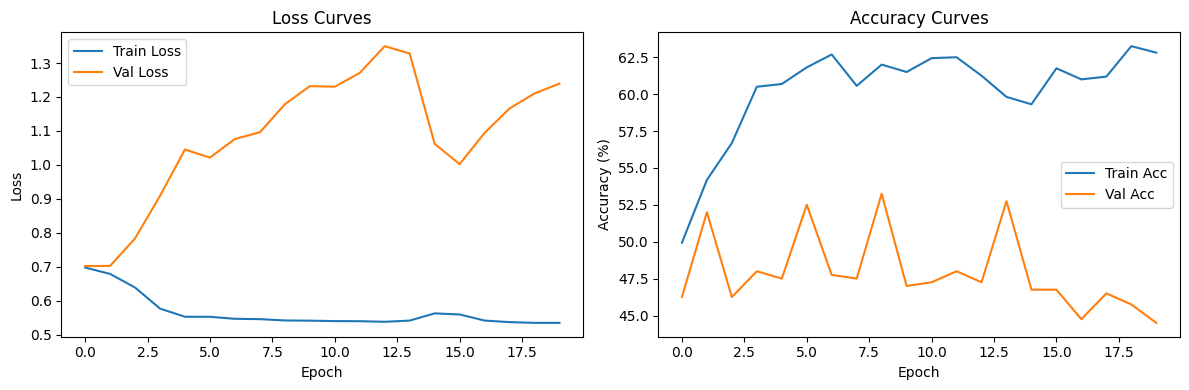


Loading models for prediction...


RuntimeError: Error(s) in loading state_dict for TextCNN:
	size mismatch for embedding.weight: copying a param with shape torch.Size([6043, 200]) from checkpoint, the shape in current model is torch.Size([6037, 200]).

In [178]:
main()

# 加载模型进行预测的示例
print("\nLoading models for prediction...")

# 加载CNN模型
cnn_checkpoint = torch.load('models/best_TextCNN.pth')
cnn_model = TextCNN(
    vocab_size=len(word_to_ix),
    embed_dim=EMBED_DIM,
    num_filters=NUM_FILTERS,
    filter_sizes=FILTER_SIZES,
    num_classes=NUM_CLASSES
).to(device)
cnn_model.load_state_dict(cnn_checkpoint['model_state_dict'])

# 加载LSTM模型
lstm_checkpoint = torch.load('models/best_TextLSTM.pth')
lstm_model = TextLSTM(
    vocab_size=len(word_to_ix),
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=NUM_CLASSES,
    num_layers=NUM_LAYERS
).to(device)
lstm_model.load_state_dict(lstm_checkpoint['model_state_dict'])

# 测试预测
test_texts = [
    "This movie was absolutely fantastic! I loved every minute of it.",
    "I really didn't enjoy this film. It was boring and predictable.",
    "The acting was great, but the plot was a bit confusing."
]

print("\nPredictions:")
for text in test_texts:
    print(f"\nText: {text}")
    cnn_sentiment, cnn_prob = predict_sentiment(cnn_model, text, word_to_ix, device)
    lstm_sentiment, lstm_prob = predict_sentiment(lstm_model, text, word_to_ix, device)
    print(f"CNN: {'Positive' if cnn_sentiment == 1 else 'Negative'} (confidence: {cnn_prob:.2f})")
    print(f"LSTM: {'Positive' if lstm_sentiment == 1 else 'Negative'} (confidence: {lstm_prob:.2f})")

- 为什么LSTM比CNN慢？
- 如果用上了GPU，对LSTM是否有加速效果？
- 为什么mean over time对LSTM很重要
- 保存的模型文件后缀一定得是.pth吗？还是只是一种习惯